In [106]:
import os
import glob

import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import seaborn as sns

from scipy import stats
from scipy.stats import binomtest
from scipy.stats import chisquare

from tqdm import tqdm

In [107]:
print(f'current working dir: {os.getcwd()}')
root_dir = r'../../DATA/3T'
print(f'{root_dir} dir exists: {os.path.exists(root_dir)}')
roots_desc = os.path.join(root_dir, '3t', '*')
path_roots = glob.glob(roots_desc)
print(roots_desc)
print(len(path_roots))

current working dir: D:\Octopus_OdorTracking\CODE\3T
../../DATA/3T dir exists: True
../../DATA/3T\3t\*
62


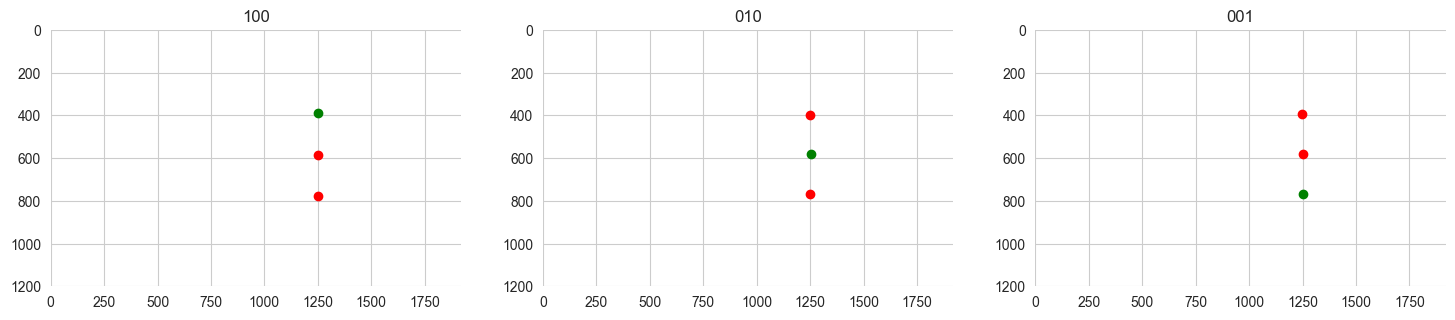

{'100': [[1250.639176103512, 390.3443574161379],
  [1249.0982809500117, 585.6089889738296],
  [1250.9084822755608, 775.489375709379]],
 '010': [[1254.6262408302541, 581.2557353186697],
  [1248.0667719917706, 398.13067049433675],
  [1250.2738199619912, 766.0967622662796]],
 '001': [[1252.485545508674, 768.788789813367],
  [1246.4743213811284, 393.9239269545489],
  [1250.6797818332652, 581.7639205235462]]}

In [108]:
path_food_pos = os.path.join(root_dir, '3t-pos-fin-key.pkl')
conditions = ['100','010','001']
food = pd.read_pickle(path_food_pos)

stations = {}

fig, axs = plt.subplots(1,3,figsize=(18,6))

for i, condition in enumerate(conditions):
    dat = food[food['condition'] == condition]
    baitKey = dat['baitKey'].tolist()[0]
    
    positions = dat['positions'].tolist()
    positions = np.array([np.array(s) for s in positions])
    
    p0 = np.array([s[0] for s in positions]).T
    p0x, p0y = np.mean(p0[0]), np.mean(p0[1])
    p1 = np.array([s[1] for s in positions]).T
    p1x, p1y = np.mean(p1[0]), np.mean(p1[1])
    p2 = np.array([s[2] for s in positions]).T
    p2x, p2y = np.mean(p2[0]), np.mean(p2[1])
    
    pX = [p0x, p1x, p2x]
    pY = [p0y, p1y, p2y]
    
    bait = [pX[baitKey].copy(), pY[baitKey].copy()]
    del pX[baitKey]
    del pY[baitKey]
    ctrl0 = [pX[0], pY[0]]
    ctrl1 = [pX[1], pY[1]]
    
    stations[condition] = [bait, ctrl0, ctrl1]
    
    ax=axs[i]
    ax.scatter(bait[0], bait[1], color='green')
    ax.scatter(ctrl0[0], ctrl0[1], color='red')
    ax.scatter(ctrl1[0], ctrl1[1], color='red')
    ax.set_xlim(0,1920)
    ax.set_ylim(1200,0)
    ax.set_aspect('equal')
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(condition)
    
plt.show(fig)
plt.close(fig)
stations

../../DATA/3T\3t\nips_10_4_100_eat_02 exists: True
../../DATA/3T\3t\khorne_9_20_010_eat_07 exists: True
../../DATA/3T\3t\slaanesh_9_7_001_eat_02 exists: True


100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


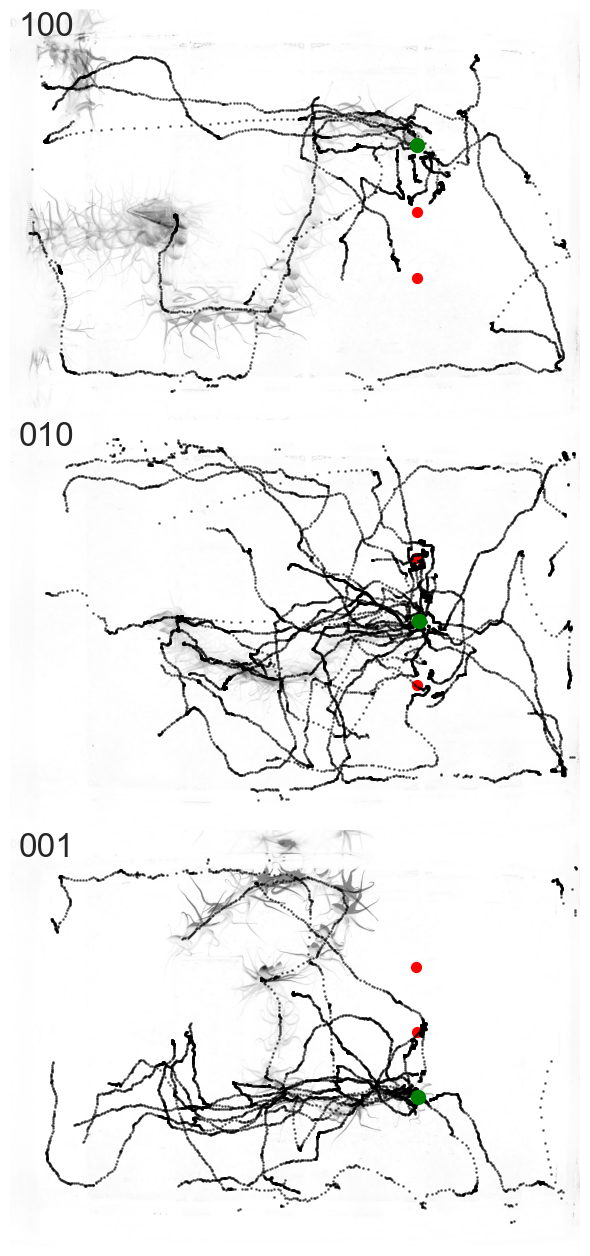

In [109]:
example_seqs = ['nips_10_4_100_eat_02', 
                'khorne_9_20_010_eat_07',
                'slaanesh_9_7_001_eat_02']
example_seqs = [os.path.join(root_dir, '3t', s) for s in example_seqs]
## check seqs exist
for seq in example_seqs:
    print(f'{seq} exists: {os.path.exists(seq)}')

pthresh = 0.6
fps = 7
tFin = int(60*fps)

ss = 14

fig, axs = plt.subplots(3,1,figsize=(6,14))

pbar = tqdm(total = 3, position=0, leave=True)
for i, condition in enumerate(conditions):
    #print(f'condition: {condition}')
    example = example_seqs[i]
    target_dir = os.path.join(root_dir, condition)
    if os.path.exists(target_dir) != True:
        #print(f'creating {target_dir}')
        os.mkdir(target_dir)
    roots = [s for s in path_roots if condition in s]
    #print(f'\t roots: {len(roots)}')
    
    station = stations[condition]
    baitX, baitY = station[0][0], station[0][1]
    ctrl0x, ctrl0y = station[1][0], station[1][1]
    ctrl1x, ctrl1y = station[2][0], station[2][1]
    
    ax=axs[i]
    vbar = tqdm(total = len(roots), position=0, leave=True)
    for root in roots:
        #print(f'root: {root}')
        path_dat = glob.glob(os.path.join(root, '*.csv'))[0]
        #print(f'\t path_dat: {path_dat}')
        dat = pd.read_csv(path_dat)
        
        if dat.shape[0] > tFin:
            dat = dat.iloc[dat.shape[0]-tFin:]
        
        lx = np.array(dat[dat.columns[2]].tolist())
        ly = np.array(dat[dat.columns[3]].tolist())
        lp = np.array(dat[dat.columns[4]].tolist())
        lp = lp >= pthresh
        rx = np.array(dat[dat.columns[5]].tolist())
        ry = np.array(dat[dat.columns[6]].tolist())
        rp = np.array(dat[dat.columns[7]].tolist())
        rp = rp > pthresh
        rp = rp*lp
        mx = (lx+rx)/2*rp
        my = (ly+ry)/2*rp
        
        ax.scatter(mx, my, s=1, color='black', alpha=0.5, zorder=4)
        
        vbar.update(n=1)
    vbar.close()
    
    ax.scatter(baitX, baitY, color='green', s=100, zorder=5)
    ax.scatter(ctrl0x, ctrl0y, color='red', s=50, zorder=2)
    ax.scatter(ctrl1x, ctrl1y, color='red', s=50, zorder=2)
    
    path_video = glob.glob(os.path.join(example, '*.mp4'))[0]
    cap = cv2.VideoCapture(path_video)
    l = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    zstack = [0]*l
    for j in range(0,l):
        success, img = cap.read()
        if success != True:
            print (j, 'failed to read', os.path.basename(path_video))
        else:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            zstack[j] = img
    zstack = zstack[::ss]
    zstack = np.array(zstack)
    std = np.std(zstack, axis=0)
    ax.imshow(std, cmap='Greys', zorder=0)
    
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_xlim(500,1520)
    ax.set_xlim(75,1720)
    ax.set_ylim(1200, 0)
    ax.set_aspect('equal')
    
    ax.text(100, 75, condition, fontsize=24)
    
    pbar.update(n=1)
pbar.close()

fig.tight_layout(h_pad = -10)
fig_name = '3t-approaches_final-approach.png'
path_fig = os.path.join(root_dir, fig_name)
fig.savefig(path_fig, dpi=300, bbox_inches='tight')

plt.show(fig)
plt.close(fig)

max time backwards from finish plotted: 20.0 minutes


100%|██████████| 3/3 [00:15<00:00,  5.23s/it]


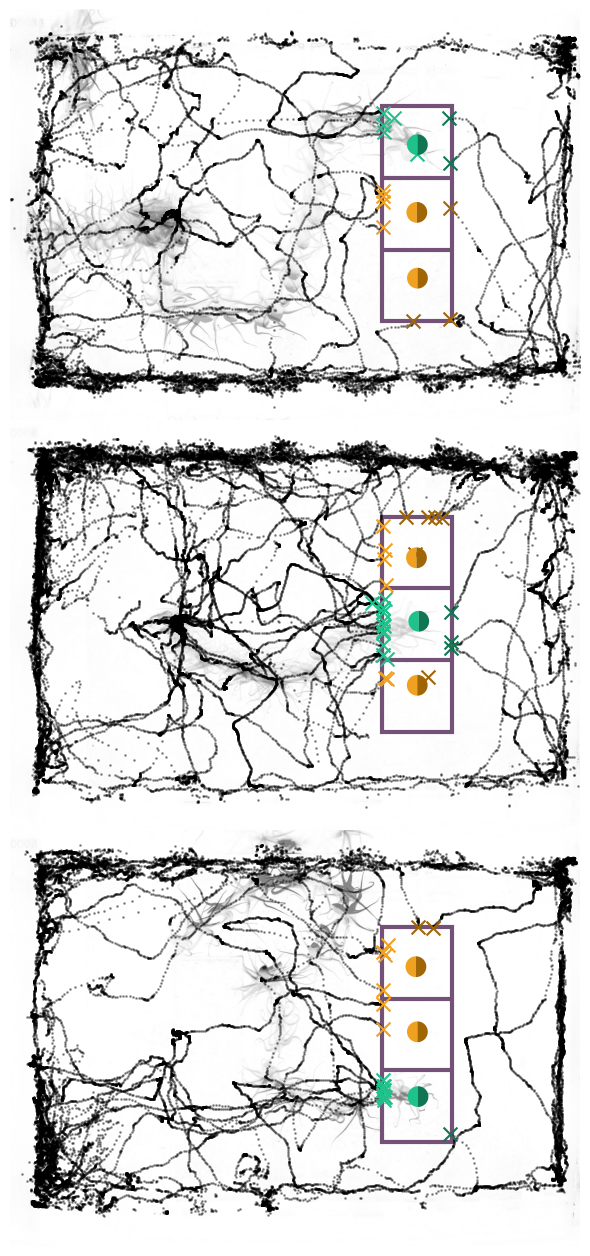

In [121]:
def check_in_box (x,y, Dx, Ux, y0, y3):
    if x >= Dx and x <= Ux and y >= y0 and y <= y3:
        return True
    else:
        return False

def check_which_box (y, y1, y2):
    if y < y1:
        return 0
    if y > y2:
        return 2
    else:
        return 1
    
def check_if_crossed_left_side (x0, x1, Dx):
    if x0 < Dx and x1 >= Dx:
        return True
    else:
        return False

def check_if_up_or_down (x, Dx):
    if x < Dx:
        return True
    else:
        return False

fin_cats = ['Bait', 'Ctrl', 'Upstream', 'In-Box', 'Upstream_Bait']
cols = ['root', 'condition', 'index', 'x', 'y', 'finish-category', 'which-box']
df = pd.DataFrame(columns = cols)

color_key = {'Bait':'#1EC38B',
             'Ctrl':'#A06505',
             'Box':'#745277',
             'Downstream_Ctrl':'#EFA121',
             'Upstream_Bait':'#107553',
             }

def create_bicolor_marker(xi, yi, r, col0, col1, ax, order):
    wedge1 = patches.Wedge(center=(xi, yi), r=r, theta1=90, theta2=270, facecolor=col0, zorder=order, edgecolor="none")
    wedge2 = patches.Wedge(center=(xi, yi), r=r, theta1=270, theta2=90, facecolor=col1, zorder=order, edgecolor="none")
    ax.add_artist(wedge1)
    ax.add_artist(wedge2)

box_edge_width = 3

marker_size = 100

box_key = {'100':0, '010':1, '001':2}

pthresh = 0.6
fps = 7
seconds = 1200
tFin = int(seconds*fps)

print(f'max time backwards from finish plotted: {seconds/60} minutes')

vertical = True

if vertical == True:
    fig, axs = plt.subplots(3,1,figsize=(6,14))
else:
    fig, axs = plt.subplots(1,3,figsize=(14,6))

pbar = tqdm(total = 3, position=0, leave=True)
for i, condition in enumerate(conditions[:]):
    ax=axs[i]
    example = example_seqs[i]
    target_dir = os.path.join(root_dir, condition)
    if os.path.exists(target_dir) != True:
        os.mkdir(target_dir)
    roots = [s for s in path_roots if condition in s]
    #roots = [roots[1], roots[2], roots[10]]
    
    station = stations[condition]
    baitX, baitY = station[0][0], station[0][1]
    ctrl0x, ctrl0y = station[1][0], station[1][1]
    ctrl1x, ctrl1y = station[2][0], station[2][1]
    
    Dx, Ux = 1150, 1350
    y0, y3 = 280, 900
    y1 = y0 + (1/3)*(y3-y0)
    y2 = y0 + (2/3)*(y3-y0)
    
    rect = plt.Rectangle((Dx, y0), (Ux-Dx), (y3-y0), edgecolor=color_key['Box'], fill=False, linewidth=box_edge_width, zorder=1)
    ax.plot([Dx,Ux], [y1, y1], color=color_key['Box'], linewidth=box_edge_width, zorder=1)
    ax.plot([Dx,Ux], [y2, y2], color=color_key['Box'], linewidth=box_edge_width, zorder=1)
    ax.add_patch(rect)

    station_size = 30
    create_bicolor_marker(baitX, baitY, station_size, color_key['Bait'], color_key['Upstream_Bait'], ax, 10)
    create_bicolor_marker(ctrl0x, ctrl0y, station_size, color_key['Downstream_Ctrl'], color_key['Ctrl'], ax, 10)
    create_bicolor_marker(ctrl1x, ctrl1y, station_size, color_key['Downstream_Ctrl'], color_key['Ctrl'], ax, 10)
    
    path_video = glob.glob(os.path.join(example, '*.mp4'))[0]
    cap = cv2.VideoCapture(path_video)
    l = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    zstack = [0]*l
    for j in range(0,l):
        success, img = cap.read()
        if success != True:
            print (j, 'failed to read', os.path.basename(path_video))
        else:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            zstack[j] = img
    zstack = zstack[::ss]
    zstack = np.array(zstack)
    std = np.std(zstack, axis=0)
    ax.imshow(std, cmap='Greys', zorder=0)
    
    vbar = tqdm(total = len(roots), position=0, leave=True)
    for root in roots:
        path_dat = glob.glob(os.path.join(root, '*.csv'))[0]
        dat = pd.read_csv(path_dat)
        
        if dat.shape[0] > tFin:
            dat = dat.iloc[dat.shape[0]-tFin:]
        
        lx = np.array(dat[dat.columns[2]].tolist())
        ly = np.array(dat[dat.columns[3]].tolist())
        lp = np.array(dat[dat.columns[4]].tolist())
        lp = lp >= pthresh
        rx = np.array(dat[dat.columns[5]].tolist())
        ry = np.array(dat[dat.columns[6]].tolist())
        rp = np.array(dat[dat.columns[7]].tolist())
        rp = rp > pthresh
        rp = rp*lp
        mx = (lx+rx)/2*rp
        my = (ly+ry)/2*rp
        
        fin_cat = ''
        which_box = ''
        fin_x = 0
        fin_y = 0
        fin_index = 0
        
        inBox = check_in_box(mx[0], my[0], Dx,Ux,y0,y3)
        if inBox == True:
            ax.scatter(mx[0], my[0], color=color_key['Ctrl'], marker = 'x', zorder=5, s=marker_size)
            which_box = check_which_box(my[0], y1, y2)
            fin_cat = fin_cats[3]
            fin_x = mx[0]
            fin_y = my[0]
            j = 1
        else:
            j = 1
            for x, y in list(zip(mx[1:], my[1:])):
                inBox = check_in_box(x,y,Dx,Ux,y0,y3)
                if inBox == True:
                    crossed_left = check_if_crossed_left_side(mx[j-1], x, Dx)
                    fin_x = x
                    fin_y = y
                    fin_index = j
                    which_box = check_which_box(y, y1, y2)
                    if crossed_left == True:
                        if box_key[condition] == which_box:
                            fin_cat = fin_cats[0]
                            ax.scatter(x, y, color=color_key['Bait'], marker = 'x', zorder=5, s=marker_size)
                        else:
                            fin_cat = fin_cats[1]
                            ax.scatter(x, y, color=color_key['Downstream_Ctrl'], marker = 'x', zorder=5, s=marker_size)
                    else:
                        if box_key[condition] == which_box:
                            fin_cat = fin_cats[4]
                            ax.scatter(x, y, color=color_key['Upstream_Bait'], marker = 'x', zorder=5, s=marker_size)
                        else:
                            fin_cat = fin_cats[2]
                            ax.scatter(x, y, color=color_key['Ctrl'], marker = 'x', zorder=5, s=marker_size)
                    break
                j += 1
            if fin_cat == '':
                downOrup = check_if_up_or_down(x, Dx)
                which_box = check_which_box(y, y1, y2)
                if downOrup == True:
                    if box_key[condition] == which_box:
                        fin_cat = fin_cats[0]
                        ax.scatter(x, y, color=color_key['Bait'], marker = 'x', zorder=5, s=marker_size)
                    else:
                        fin_cat = fin_cats[1]
                        ax.scatter(x, y, color=color_key['Downstream_Ctrl'], marker = 'x', zorder=5, s=marker_size)
                else:
                    fin_cat = fin_cats[2]
                    ax.scatter(x, y, color=color_key['Ctrl'], marker = 'x', zorder=5, s=marker_size)
        
        dftmp = pd.DataFrame(list(zip([root], [condition], [fin_index],
                                     [fin_x], [fin_y], [fin_cat], [which_box])),
                            columns=cols)
        df = pd.concat([df, dftmp])
        
        ax.scatter(mx[:j], my[:j], s=1, color='black', alpha=0.35, zorder=4)
        
        vbar.update(n=1)
    vbar.close()

    #if i == 2 and vertical == True:
        ## draw arrow across the bottom of the x-axis pointing from right to left
      #  ax.arrow(.9, .01, -.7, 0, head_width=0.05, head_length=0.05, fc=color_key['Box'], ec=color_key['Box'], transform=ax.transAxes, zorder=8, linewidth=3)
     #   ## add text just above end of the arrow saying "Net flow direction"
     #   ax.text(.4, 0.02, 'Net flow direction', transform=ax.transAxes, ha='left', va='bottom', fontsize=14, fontweight='bold', zorder=8, color=color_key['Box'])


    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_xlim(500,1520)
    ax.set_xlim(75,1720)
    ax.set_ylim(1200, 0)
    ax.set_aspect('equal')
    
    #ax.text(100, 75, condition, fontsize=24, fontweight='bold', zorder=7)
    # white rectangle behind text
    #ax.add_patch(patches.Rectangle((100, 75), 175, -100, color='white', zorder=6))
    
    pbar.update(n=1)
pbar.close()

"""## define a custom legend
lines = [Line2D([0], [0], color=color_key['Bait'], marker = 'x', markersize=10, lw=0, markeredgewidth=2),
         Line2D([0], [0], color=color_key['Upstream_Bait'], marker = 'x', markersize=10, lw=0, markeredgewidth=2),
         Line2D([0], [0], color=color_key['Downstream_Ctrl'], marker = 'x', markersize=10, lw=0, markeredgewidth=2),
         Line2D([0], [0], color=color_key['Ctrl'], marker = 'x', markersize=10, lw=0, markeredgewidth=2),]

labels = [r'$\bf{Against\,Flow:}$ Bait', r'$\bf{With\,Flow:}$ Bait', r'$\bf{Against\,Flow:}$ Control', r'$\bf{With\,Flow:}$ Control']
## add legend to ax[0]
if vertical == True:
    axs[0].legend(lines, labels, loc='upper left', bbox_to_anchor=(-0.02, 0.96), fontsize=12,
              frameon=True, edgecolor='none', facecolor='white', framealpha=1)
else:
    axs[2].legend(lines, labels, loc='upper left', bbox_to_anchor=(-0.02, 0.96), fontsize=12,
                  frameon=True, edgecolor='none', facecolor='white', framealpha=1)
"""
up_down_cats = []
for cat in df['finish-category'].tolist():
    if cat == fin_cats[2] or cat == fin_cats[3]:
        up_down_cats.append('Upstream')
    else:
        up_down_cats.append('Downstream')
df['Approach-Category'] = up_down_cats

fig.tight_layout(h_pad = -10)
if vertical == True:
    fig_name = '3t-approaches_final-approach-categories_vertical.png'
else:
    fig_name = '3t-approaches_final-approach-categories_horizontal.png'
path_fig0 = os.path.join(root_dir, fig_name)
fig.savefig(path_fig0, dpi=300, bbox_inches='tight')

plt.show(fig)
plt.close(fig)

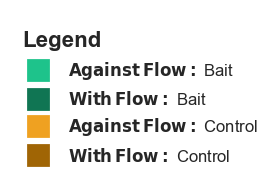

In [111]:
fig, (ax) = plt.subplots(1,1, figsize=(2.5,5))

ax.grid(color='white')
ax.set_aspect('equal')

## define a custom legend
lines = [Line2D([0], [0], color=color_key['Bait'], marker = "s", markersize=14, lw=0, markeredgewidth=2),
         Line2D([0], [0], color=color_key['Upstream_Bait'], marker = "s", markersize=14, lw=0, markeredgewidth=2),
         Line2D([0], [0], color=color_key['Downstream_Ctrl'], marker = "s", markersize=14, lw=0, markeredgewidth=2),
         Line2D([0], [0], color=color_key['Ctrl'], marker = "s", markersize=14, lw=0, markeredgewidth=2),]

labels = [r'$\bf{Against\,Flow:}$ Bait', r'$\bf{With\,Flow:}$ Bait', r'$\bf{Against\,Flow:}$ Control', r'$\bf{With\,Flow:}$ Control']

legend = ax.legend(lines, labels, loc='upper left', bbox_to_anchor=(-0.02, 0.96), fontsize=12,
                    frameon=True, edgecolor='none', facecolor='white', framealpha=1)
legend.set_title("Legend", prop={"size": 16}, )  # replace 'Your Title' with the desired title
legend._legend_box.align = "left"
legend.get_title().set_fontweight('bold')

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

fig.tight_layout()
fig_name = '3t-approaches_legend.png'
path_fig1 = os.path.join(root_dir, fig_name)
fig.savefig(path_fig1, dpi=300, bbox_inches='tight')

plt.show(fig)
plt.close(fig)

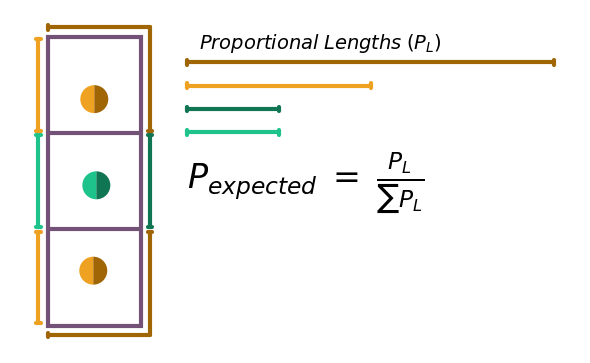

In [112]:
fig, (ax) = plt.subplots(1,1,figsize=(6,5))

for i, condition in enumerate(conditions[1:2]):
    station = stations[condition]
    baitX, baitY = station[0][0], station[0][1]
    ctrl0x, ctrl0y = station[1][0], station[1][1]
    ctrl1x, ctrl1y = station[2][0], station[2][1]

    ## draw box
    Dx, Ux = 1150, 1350
    y0, y3 = 280, 900
    y1 = y0 + (1/3)*(y3-y0)
    y2 = y0 + (2/3)*(y3-y0)

    rect = plt.Rectangle((Dx, y0), (Ux-Dx), (y3-y0), edgecolor=color_key['Box'], fill=False, linewidth=box_edge_width, zorder=1)
    ax.plot([Dx,Ux], [y1, y1], color=color_key['Box'], linewidth=box_edge_width, zorder=1)
    ax.plot([Dx,Ux], [y2, y2], color=color_key['Box'], linewidth=box_edge_width, zorder=1)
    ax.add_patch(rect)

    station_size = 30
    create_bicolor_marker(baitX, baitY, station_size, color_key['Bait'], color_key['Upstream_Bait'], ax, 10)
    create_bicolor_marker(ctrl0x, ctrl0y, station_size, color_key['Downstream_Ctrl'], color_key['Ctrl'], ax, 10)
    create_bicolor_marker(ctrl1x, ctrl1y, station_size, color_key['Downstream_Ctrl'], color_key['Ctrl'], ax, 10)

    ## draw by region edges of the boxes
    shrink_y = 5
    shrink_x = 2
    offsetx = 20
    offsety = 20
    capsize = 5
    ax.plot([Dx-offsetx, Dx-offsetx], [y1+shrink_y, y2-shrink_y], color=color_key['Bait'], linewidth=box_edge_width, zorder=1)
    ax.plot([Dx-capsize-offsetx, Dx+capsize-offsetx], [y1+shrink_y, y1+shrink_y], color=color_key['Bait'], linewidth=box_edge_width, zorder=1)
    ax.plot([Dx-capsize-offsetx, Dx+capsize-offsetx], [y2-shrink_y, y2-shrink_y], color=color_key['Bait'], linewidth=box_edge_width, zorder=1)

    ax.plot([Ux+offsetx, Ux+offsetx], [y1+shrink_y, y2-shrink_y], color=color_key['Upstream_Bait'], linewidth=box_edge_width, zorder=1)
    ax.plot([Ux-capsize+offsetx, Ux+capsize+offsetx], [y1+shrink_y, y1+shrink_y], color=color_key['Upstream_Bait'], linewidth=box_edge_width, zorder=1)
    ax.plot([Ux-capsize+offsetx, Ux+capsize+offsetx], [y2-shrink_y, y2-shrink_y], color=color_key['Upstream_Bait'], linewidth=box_edge_width, zorder=1)

    ax.plot([Dx-offsetx, Dx-offsetx], [y0+shrink_y, y1-shrink_y], color=color_key['Downstream_Ctrl'], linewidth=box_edge_width, zorder=1)
    ax.plot([Dx-capsize-offsetx, Dx+capsize-offsetx], [y0+shrink_y, y0+shrink_y], color=color_key['Downstream_Ctrl'], linewidth=box_edge_width, zorder=1)
    ax.plot([Dx-capsize-offsetx, Dx+capsize-offsetx], [y1-shrink_y, y1-shrink_y], color=color_key['Downstream_Ctrl'], linewidth=box_edge_width, zorder=1)

    ax.plot([Dx-offsetx, Dx-offsetx], [y2+shrink_y, y3-shrink_y], color=color_key['Downstream_Ctrl'], linewidth=box_edge_width, zorder=1)
    ax.plot([Dx-capsize-offsetx, Dx+capsize-offsetx], [y2+shrink_y, y2+shrink_y], color=color_key['Downstream_Ctrl'], linewidth=box_edge_width, zorder=1)
    ax.plot([Dx-capsize-offsetx, Dx+capsize-offsetx], [y3-shrink_y, y3-shrink_y], color=color_key['Downstream_Ctrl'], linewidth=box_edge_width, zorder=1)

    ax.plot([Ux+offsetx, Dx+shrink_x], [y0-offsety, y0- offsety], color=color_key['Ctrl'], linewidth=box_edge_width, zorder=1)
    ax.plot([Dx+shrink_x, Dx+shrink_x], [y0-capsize-offsety, y0+capsize-offsety], color=color_key['Ctrl'], linewidth=box_edge_width, zorder=1)
    ax.plot([Ux+offsetx, Ux+offsetx], [y0-offsety, y1-shrink_y], color=color_key['Ctrl'], linewidth=box_edge_width, zorder=1)
    ax.plot([Ux-capsize+offsetx, Ux+capsize+offsetx], [y1-shrink_y, y1-shrink_y], color=color_key['Ctrl'], linewidth=box_edge_width, zorder=1)

    ax.plot([Ux+offsetx, Dx+shrink_x], [y3+offsety, y3+offsety], color=color_key['Ctrl'], linewidth=box_edge_width, zorder=1)
    ax.plot([Dx+shrink_x, Dx+shrink_x], [y3-capsize+offsety, y3+capsize+offsety], color=color_key['Ctrl'], linewidth=box_edge_width, zorder=1)
    ax.plot([Ux+offsetx, Ux+offsetx], [y2+shrink_y, y3+offsety], color=color_key['Ctrl'], linewidth=box_edge_width, zorder=1)
    ax.plot([Ux-capsize+offsetx, Ux+capsize+offsetx], [y2+shrink_y, y2+shrink_y], color=color_key['Ctrl'], linewidth=box_edge_width, zorder=1)

    ## draw porportional lengths which are flatted edges by class to the right of the box
    offsetFx = 100
    downshifty = 50
    steps = 0.5

    ax.text(Ux+1.25*offsetFx, y3-offsety-steps*downshifty+20, '$Proportional$ $Lengths$ $(P_L)$', color='black', fontsize=14, zorder=1)

    steps += 1
    length_ctrl = 4*((y2-shrink_y)-(y1+shrink_y))
    ax.plot([Ux+offsetFx, Ux+offsetFx + length_ctrl], [y3+offsety-steps*downshifty, y3+offsety-steps*downshifty], color=color_key['Ctrl'], linewidth=box_edge_width, zorder=1)
    ax.plot([Ux+offsetFx, Ux+offsetFx], [y3+offsety-steps*downshifty-capsize, y3+offsety-steps*downshifty+capsize], color=color_key['Ctrl'], linewidth=box_edge_width, zorder=1)
    ax.plot([Ux+offsetFx + length_ctrl, Ux+offsetFx + length_ctrl], [y3+offsety-steps*downshifty-capsize, y3+offsety-steps*downshifty+capsize], color=color_key['Ctrl'], linewidth=box_edge_width, zorder=1)

    steps += 1
    length_downstream_ctrl = 2*((y2-shrink_y)-(y1+shrink_y))
    ax.plot([Ux+offsetFx, Ux+offsetFx + length_downstream_ctrl], [y3+offsety-steps*downshifty, y3+offsety-steps*downshifty], color=color_key['Downstream_Ctrl'], linewidth=box_edge_width, zorder=1)
    ax.plot([Ux+offsetFx, Ux+offsetFx], [y3+offsety-steps*downshifty-capsize, y3+offsety-steps*downshifty+capsize], color=color_key['Downstream_Ctrl'], linewidth=box_edge_width, zorder=1)
    ax.plot([Ux+offsetFx + length_downstream_ctrl, Ux+offsetFx + length_downstream_ctrl], [y3+offsety-steps*downshifty-capsize, y3+offsety-steps*downshifty+capsize], color=color_key['Downstream_Ctrl'], linewidth=box_edge_width, zorder=1)

    steps += 1
    length_upstream_bait = ((y2-shrink_y)-(y1+shrink_y))
    ax.plot([Ux+offsetFx, Ux+offsetFx + length_upstream_bait], [y3+offsety-steps*downshifty, y3+offsety-steps*downshifty], color=color_key['Upstream_Bait'], linewidth=box_edge_width, zorder=1)
    ax.plot([Ux+offsetFx, Ux+offsetFx], [y3+offsety-steps*downshifty-capsize, y3+offsety-steps*downshifty+capsize], color=color_key['Upstream_Bait'], linewidth=box_edge_width, zorder=1)
    ax.plot([Ux+offsetFx + length_upstream_bait, Ux+offsetFx + length_upstream_bait], [y3+offsety-steps*downshifty-capsize, y3+offsety-steps*downshifty+capsize], color=color_key['Upstream_Bait'], linewidth=box_edge_width, zorder=1)

    steps += 1
    length_bait = ((y2-shrink_y)-(y1+shrink_y))
    ax.plot([Ux+offsetFx, Ux+offsetFx + length_bait], [y3+offsety-steps*downshifty, y3+offsety-steps*downshifty], color=color_key['Bait'], linewidth=box_edge_width, zorder=1)
    ax.plot([Ux+offsetFx, Ux+offsetFx], [y3+offsety-steps*downshifty-capsize, y3+offsety-steps*downshifty+capsize], color=color_key['Bait'], linewidth=box_edge_width, zorder=1)
    ax.plot([Ux+offsetFx + length_bait, Ux+offsetFx + length_bait], [y3+offsety-steps*downshifty-capsize, y3+offsety-steps*downshifty+capsize], color=color_key['Bait'], linewidth=box_edge_width, zorder=1)

    """
    ## draw the normalized lengths
    steps += 2
    ax.text(Ux+1.25*offsetFx, y3-offsety-steps*downshifty+20, '$Corrected$ $Lengths$ $(C_L)$', color='black', fontsize=14, zorder=1)

    steps += 1
    length_ctrl = 2*((y2-shrink_y)-(y1+shrink_y))
    ax.plot([Ux+offsetFx, Ux+offsetFx + length_ctrl], [y3+offsety-steps*downshifty, y3+offsety-steps*downshifty], color=color_key['Ctrl'], linewidth=box_edge_width, zorder=1)
    ax.plot([Ux+offsetFx, Ux+offsetFx], [y3+offsety-steps*downshifty-capsize, y3+offsety-steps*downshifty+capsize], color=color_key['Ctrl'], linewidth=box_edge_width, zorder=1)
    ax.plot([Ux+offsetFx + length_ctrl, Ux+offsetFx + length_ctrl], [y3+offsety-steps*downshifty-capsize, y3+offsety-steps*downshifty+capsize], color=color_key['Ctrl'], linewidth=box_edge_width, zorder=1)

    steps += 1
    length_downstream_ctrl = 1*((y2-shrink_y)-(y1+shrink_y))
    ax.plot([Ux+offsetFx, Ux+offsetFx + length_downstream_ctrl], [y3+offsety-steps*downshifty, y3+offsety-steps*downshifty], color=color_key['Downstream_Ctrl'], linewidth=box_edge_width, zorder=1)
    ax.plot([Ux+offsetFx, Ux+offsetFx], [y3+offsety-steps*downshifty-capsize, y3+offsety-steps*downshifty+capsize], color=color_key['Downstream_Ctrl'], linewidth=box_edge_width, zorder=1)
    ax.plot([Ux+offsetFx + length_downstream_ctrl, Ux+offsetFx + length_downstream_ctrl], [y3+offsety-steps*downshifty-capsize, y3+offsety-steps*downshifty+capsize], color=color_key['Downstream_Ctrl'], linewidth=box_edge_width, zorder=1)

    steps += 1
    length_upstream_bait = ((y2-shrink_y)-(y1+shrink_y))
    ax.plot([Ux+offsetFx, Ux+offsetFx + length_upstream_bait], [y3+offsety-steps*downshifty, y3+offsety-steps*downshifty], color=color_key['Upstream_Bait'], linewidth=box_edge_width, zorder=1)
    ax.plot([Ux+offsetFx, Ux+offsetFx], [y3+offsety-steps*downshifty-capsize, y3+offsety-steps*downshifty+capsize], color=color_key['Upstream_Bait'], linewidth=box_edge_width, zorder=1)
    ax.plot([Ux+offsetFx + length_upstream_bait, Ux+offsetFx + length_upstream_bait], [y3+offsety-steps*downshifty-capsize, y3+offsety-steps*downshifty+capsize], color=color_key['Upstream_Bait'], linewidth=box_edge_width, zorder=1)

    steps += 1
    length_bait = ((y2-shrink_y)-(y1+shrink_y))
    ax.plot([Ux+offsetFx, Ux+offsetFx + length_bait], [y3+offsety-steps*downshifty, y3+offsety-steps*downshifty], color=color_key['Bait'], linewidth=box_edge_width, zorder=1)
    ax.plot([Ux+offsetFx, Ux+offsetFx], [y3+offsety-steps*downshifty-capsize, y3+offsety-steps*downshifty+capsize], color=color_key['Bait'], linewidth=box_edge_width, zorder=1)
    ax.plot([Ux+offsetFx + length_bait, Ux+offsetFx + length_bait], [y3+offsety-steps*downshifty-capsize, y3+offsety-steps*downshifty+capsize], color=color_key['Bait'], linewidth=box_edge_width, zorder=1)
    """

## draw the equation for expected probability of occurance based upon summed normalized lengths
steps += 2
ax.text(Ux+1*offsetFx, y3-offsety-steps*downshifty+20, '$P_{expected}$ $=$ $\\frac{P_L}{\\sum P_L}$', color='black', fontsize=24, zorder=1)

ax.grid(color='white')
ax.set_aspect('equal')

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

fig.tight_layout()
fig_name = '3t-approaches_expectations.png'
path_fig1 = os.path.join(root_dir, fig_name)
fig.savefig(path_fig1, dpi=300, bbox_inches='tight')

plt.show(fig)
plt.close(fig)

In [113]:
Nl = length_ctrl + length_downstream_ctrl + length_upstream_bait + length_bait
Pctrl = length_ctrl/Nl
Pdownstream_ctrl = length_downstream_ctrl/Nl
Pupstream_bait = length_upstream_bait/Nl
Pbait = length_bait/Nl

Pctrl_upstreambait = Pctrl + Pupstream_bait

print(f'Pctrl: {Pctrl}')
print(f'Pdownstream_ctrl: {Pdownstream_ctrl}')
print(f'Pupstream_bait: {Pupstream_bait}')
print(f'Pbait: {Pbait}')
print()
print(f'Pctrl + Pupstreambait: {round(Pctrl_upstreambait,3)}')
print()

ExpectationsKey = ['Into Flow Bait', 'Into Flow Control', 'With Flow']
print(f'ExpectationsKey: {ExpectationsKey}')
Pexpectations = [Pbait, Pdownstream_ctrl, round(Pctrl_upstreambait,3)]
print(f'Pexpectations: {Pexpectations}')

Psum = sum(Pexpectations)
print(f'Psum: {Psum}')

Pctrl: 0.5
Pdownstream_ctrl: 0.25
Pupstream_bait: 0.125
Pbait: 0.125

Pctrl + Pupstreambait: 0.625

ExpectationsKey: ['Into Flow Bait', 'Into Flow Control', 'With Flow']
Pexpectations: [0.125, 0.25, 0.625]
Psum: 1.0


100, {'Bait': 5, 'Upstream_Bait': 2, 'Ctrl': 0, 'Upstream_Ctrl': 0}
100, {'Bait': 5, 'Upstream_Bait': 2, 'Ctrl': 4, 'Upstream_Ctrl': 1}
100, {'Bait': 5, 'Upstream_Bait': 2, 'Ctrl': 4, 'Upstream_Ctrl': 3}

010, {'Bait': 0, 'Upstream_Bait': 0, 'Ctrl': 4, 'Upstream_Ctrl': 5}
010, {'Bait': 14, 'Upstream_Bait': 3, 'Ctrl': 4, 'Upstream_Ctrl': 5}
010, {'Bait': 14, 'Upstream_Bait': 3, 'Ctrl': 6, 'Upstream_Ctrl': 6}

001, {'Bait': 0, 'Upstream_Bait': 0, 'Ctrl': 4, 'Upstream_Ctrl': 2}
001, {'Bait': 0, 'Upstream_Bait': 0, 'Ctrl': 6, 'Upstream_Ctrl': 2}
001, {'Bait': 9, 'Upstream_Bait': 1, 'Ctrl': 6, 'Upstream_Ctrl': 2}



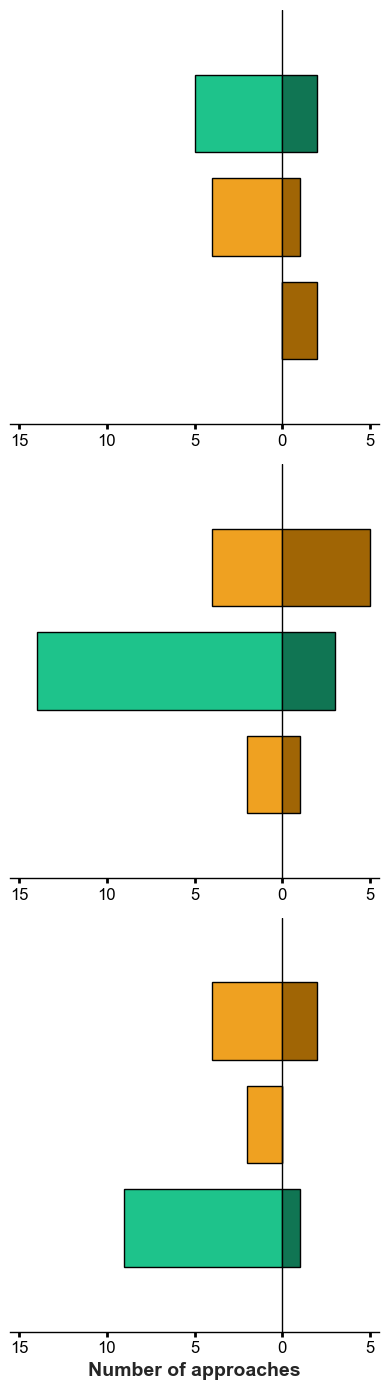

In [114]:

fig, axs = plt.subplots(3, 1, figsize=(4,14))

xlim = (-5.5, 15.5)
xticks = [-5, 0, 5, 10, 15]
xlabs = [abs(x) for x in xticks]
ylim = (-1, 3)

bar_width = 0.75

condition_sums_dict = {condition:{'Bait':0, 'Upstream_Bait':0, 'Ctrl':0, 'Upstream_Ctrl':0} for condition in conditions}

for i, condition in enumerate(conditions):
    #print(f'Plotting {condition}...')
    ax = axs[i]
    ax.grid(color='white')
    dat = df[df['condition'] == condition]

    target = box_key[condition]
    #print(f'Target box: {condition}: {target}')
    #print(f'Number of approaches: {dat.shape[0]}')
    #print(f'Unique finish-categories: {dat["finish-category"].unique()}')

    leftcols = []
    rightcols = []
    summary_downstreams = []
    summary_upstreams = []
    ## get summary by which-box
    for whichbox in [0, 1, 2]:
        tmp = dat[dat['which-box'] == whichbox]
        if whichbox == target:
            leftcol = color_key['Bait']
            rightcol = color_key['Upstream_Bait']
            leftcols.append(leftcol)
            rightcols.append(rightcol)
            sum_downstream = tmp[tmp['finish-category'] == 'Bait'].shape[0]
            sum_upstream = -tmp[tmp['finish-category'] == 'Upstream_Bait'].shape[0]
            summary_downstreams.append(sum_downstream)
            summary_upstreams.append(sum_upstream)
            condition_sums_dict[condition]['Bait'] += sum_downstream
            condition_sums_dict[condition]['Upstream_Bait'] -= sum_upstream
            print(f'{condition}, {condition_sums_dict[condition]}')
        else:
            leftcol = color_key['Downstream_Ctrl']
            rightcol = color_key['Ctrl']
            leftcols.append(leftcol)
            rightcols.append(rightcol)
            sum_downstream = tmp[tmp['finish-category'] == 'Ctrl'].shape[0]
            sum_upstream = -tmp[(tmp['finish-category'] == 'Upstream') | (tmp['finish-category'] == 'In-Box')].shape[0]
            summary_downstreams.append(sum_downstream)
            summary_upstreams.append(sum_upstream)
            condition_sums_dict[condition]['Ctrl'] += sum_downstream
            condition_sums_dict[condition]['Upstream_Ctrl'] -= sum_upstream
            print(f'{condition}, {condition_sums_dict[condition]}')

    #print(f'{condition} summary downstreams: {summary_downstreams}')
    #print(f'{condition} summary upstreams: {summary_upstreams}')
    pos = [2, 1, 0]
    ## horizontal bar plot of the downstreams
    ax.barh(pos, summary_downstreams, color=leftcols, edgecolor='black', lw=1, zorder=3, height=bar_width)
    ## horizontal bar plot of the upstreams
    ax.barh(pos, summary_upstreams, color=rightcols, edgecolor='black', lw=1, zorder=3, height=bar_width)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.invert_xaxis()
    ax.axvline(x=0, color='black', lw=1)

    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabs, fontsize=12)

    ax.set_yticks([])

    ## set ticks to visible
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)

    ## make the ticks markers thicker
    ax.tick_params(axis='x', width=2, colors='black')

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ## make the spline thicker and black
    for axis in ['bottom']:
        ax.spines[axis].set_linewidth(1)
        ax.spines[axis].set_color('black')

    ## add condition label as text just above the x-axis
    #ax.text(14.5, ylim[1]-0.25, condition, fontsize=18, ha='center', va='bottom',fontweight='bold', color='black')

    if i == 2:
        ax.set_xlabel('Number of approaches', fontsize=14, fontweight='bold',)

    print()


fig.tight_layout()
fig_name = '3t-approaches_final-approach-horizontal_bar.png'
path_fig1 = os.path.join(root_dir, fig_name)
fig.savefig(path_fig1, dpi=300, bbox_inches='tight')

plt.show(fig)
plt.close(fig)

In [115]:
condition_sums_dict

{'100': {'Bait': 5, 'Upstream_Bait': 2, 'Ctrl': 4, 'Upstream_Ctrl': 3},
 '010': {'Bait': 14, 'Upstream_Bait': 3, 'Ctrl': 6, 'Upstream_Ctrl': 6},
 '001': {'Bait': 9, 'Upstream_Bait': 1, 'Ctrl': 6, 'Upstream_Ctrl': 2}}

100 sum counts: 14
100 observed counts: [5 4 5]
100 expected counts: [1.75 3.5  8.75]
Chi-square statistic: 7.7142857142857135, p-value: 0.02112827988118329
expected proportion bait: 0.3333333333333333, total events: 9, bait events: 5, expected bait events: 3.0
binom test p-value (bait vs downstream ctrl): BinomTestResult(k=5, n=9, alternative='two-sided', statistic=0.5555555555555556, pvalue=0.17085810089925318)
expected proportion ctrl: 0.2857142857142857, total events: 9, ctrl events: 4, expected ctrl events: 2.571428571428571
binom test p-value (downstream ctrl vs upstream): BinomTestResult(k=4, n=9, alternative='two-sided', statistic=0.4444444444444444, pvalue=0.2867737944714583)

010 sum counts: 29
010 observed counts: [14  6  9]
010 expected counts: [ 3.625  7.25  18.125]
Chi-square statistic: 34.50344827586207, p-value: 3.2186325840452834e-08
expected proportion bait: 0.3333333333333333, total events: 20, bait events: 14, expected bait events: 6.666666666666666
binom test p-val

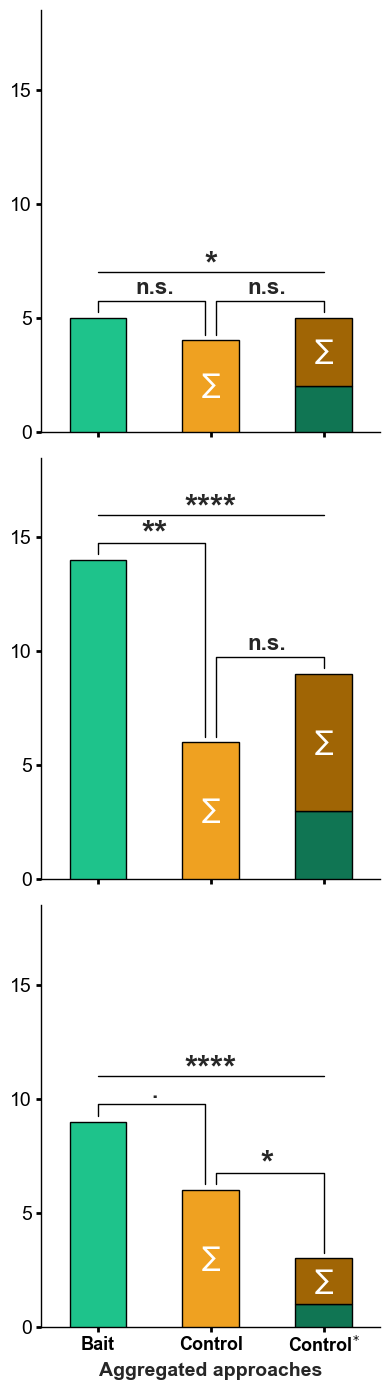

In [116]:
def convert_p_to_asterisks(p):
    if p < 0.0001:
        return '****'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    elif p < 0.1:
        return '.'
    else:
        return 'n.s.'

fig, axs = plt.subplots(3, 1, figsize=(4,14))

xticks = [0, 1, 2]
xlabs = [r'Bait', r'Control', r'Control$^{*}$']

yticks = [0, 5, 10, 15]
ylim = (0, 18.5)
xlim = (-.5, 2.5)

sums_bait = 0
sums_upstream_bait = 0
sums_ctrl = 0
sums_upstream_ctrl = 0

for i, condition in enumerate(conditions):
    ax = axs[i]

    ax.grid(color='white')

    sums_dict = condition_sums_dict[condition]

    bait = sums_dict['Bait']
    sums_bait += bait
    upstream_bait = sums_dict['Upstream_Bait']
    sums_upstream_bait += upstream_bait
    ctrl = sums_dict['Ctrl']
    sums_ctrl += ctrl
    upstream_ctrl = sums_dict['Upstream_Ctrl']
    sums_upstream_ctrl += upstream_ctrl

    #ExpectationsKey: ['Into Flow Bait', 'Into Flow Control', 'With Flow']
    #Pexpectations: [0.2, 0.2, 0.6]

    sum_counts = bait + upstream_bait + ctrl + upstream_ctrl
    observed_counts = np.array([bait, ctrl, upstream_bait+upstream_ctrl])
    expected_counts = np.array([sum_counts * Pexpectations[0], sum_counts * Pexpectations[1], sum_counts * Pexpectations[2]])
    print(f'{condition} sum counts: {sum_counts}')
    print(f'{condition} observed counts: {observed_counts}')
    print(f'{condition} expected counts: {expected_counts}')

    # Perform Chi-square test
    chi2, p_val_chi = chisquare(observed_counts, expected_counts)
    print(f'Chi-square statistic: {chi2}, p-value: {p_val_chi}')

    ## compare bait to downstream_ctrl with binom
    #Nl = length_ctrl + length_downstream_ctrl + length_upstream_bait + length_bait
    expected_proportion = length_bait / (length_bait + length_downstream_ctrl)
    total_events = bait + ctrl
    print(f'expected proportion bait: {expected_proportion}, total events: {total_events}, bait events: {bait}, expected bait events: {expected_proportion * total_events}')
    p_val_BC = binomtest(bait, total_events, expected_proportion, alternative='two-sided')
    print(f'binom test p-value (bait vs downstream ctrl): {p_val_BC}')

    ## compare downstream ctrl to upstream_bait + upstream_ctrl with binom
    expected_proportion = length_downstream_ctrl / (length_ctrl + length_downstream_ctrl + length_upstream_bait)
    total_events = ctrl + upstream_bait + upstream_ctrl
    print(f'expected proportion ctrl: {expected_proportion}, total events: {total_events}, ctrl events: {ctrl}, expected ctrl events: {expected_proportion * total_events}')
    p_val_CC = binomtest(ctrl, total_events, expected_proportion, alternative='two-sided')
    print(f'binom test p-value (downstream ctrl vs upstream): {p_val_CC}')

    ## make bar chart
    # bait as single bar
    # ctrl as single bar
    # upstream bait and upstream ctrl as stacked bar

    ## bar widths
    bar_width = 0.5
    ## x positions
    x_bait = 0
    x_ctrl = 1
    x_upstream = 2

    ## y positions
    y_bait = bait
    y_ctrl = ctrl
    y_upstream_bait = upstream_bait
    y_upstream_ctrl = upstream_ctrl

    ## colors
    color_bait = color_key['Bait']
    color_ctrl = color_key['Downstream_Ctrl']
    color_upstream_bait = color_key['Upstream_Bait']
    color_upstream_ctrl = color_key['Ctrl']

    ## plot bait
    ax.bar(x_bait, y_bait, color=color_bait, edgecolor='black', lw=1, zorder=3, width=bar_width)
    ## plot ctrl
    ax.bar(x_ctrl, y_ctrl, color=color_ctrl, edgecolor='black', lw=1, zorder=3, width=bar_width)
    ## plot upstream bait
    ax.bar(x_upstream, y_upstream_bait, color=color_upstream_bait, edgecolor='black', lw=1, zorder=3, width=bar_width)
    ## plot upstream ctrl
    ax.bar(x_upstream, y_upstream_ctrl, bottom=y_upstream_bait, color=color_upstream_ctrl, edgecolor='black', lw=1, zorder=3, width=bar_width)

    ## draw line connecting top of bait and ctrl bars to show p_val_BC
    offsetx = 0.05
    offsety = .25
    gapy = .5
    pady = .8
    px = [x_bait, x_bait, x_ctrl-offsetx, x_ctrl-offsetx]
    py = [y_bait+offsety, y_bait+offsety+gapy, y_bait+offsety+gapy, y_ctrl+offsety]
    ax.plot(px, py, color='black', lw=1, zorder=4)
    ## add p_val_BC to plot
    p = convert_p_to_asterisks(p_val_BC.pvalue)
    fs = 16
    downy = 0
    if '*' in p:
        fs = 24
        downy = .2
    ax.text(x_bait+(x_ctrl-x_bait)/2, y_bait+offsety+gapy/2+pady-downy, f'{p}', fontsize=fs, ha='center', va='center', fontweight='bold')

    # draw line connecting top of ctrl and upstream ctrl bars to show p_val_CC
    px = [x_ctrl+offsetx, x_ctrl+offsetx, x_upstream, x_upstream]
    if y_ctrl < y_upstream_ctrl + y_upstream_bait:
        py = [y_ctrl+offsety, y_upstream_ctrl+y_upstream_bait+offsety+gapy, y_upstream_ctrl+y_upstream_bait+offsety+gapy, y_upstream_ctrl+y_upstream_bait+offsety]
    else:
        py = [y_ctrl+offsety, y_ctrl+offsety+gapy, y_ctrl+offsety+gapy, y_upstream_ctrl+y_upstream_bait+offsety]
    ax.plot(px, py, color='black', lw=1, zorder=4)
    ## add p_val_CC to plot
    p = convert_p_to_asterisks(p_val_CC.pvalue)
    fs = 16
    downy = 0
    if '*' in p:
        fs = 24
        downy = .2
    ax.text(x_ctrl+(x_upstream-x_ctrl)/2, py[2]+gapy+pady-downy-(offsety+gapy), f'{p}', fontsize=fs, ha='center', va='center', fontweight='bold')

    ## draw line across the top for reporting the chisq
    gapy = 2
    px = [x_bait, x_upstream]
    y = max([y_bait, y_ctrl, y_upstream_bait+y_upstream_ctrl])
    py = [y+gapy, y+gapy]
    ax.plot(px, py, color='black', lw=1, zorder=4)
    ## add chisq to plot
    p = convert_p_to_asterisks(p_val_chi)
    fs = 16
    gapy = 0.5
    downy = 0
    if '*' in p:
        fs = 24
        downy = .25
    ax.text(x_bait+(x_upstream-x_bait)/2, py[0]+gapy-downy, f'{p}', fontsize=fs, ha='center', va='center', fontweight='bold')

    ## add sum symbol to inside of ctrl bar
    ax.text(x_ctrl, y_ctrl*(1/2), '$\\sum{}$', fontsize=14, ha='center', va='center', fontweight='bold', color='white')
    ## add sum symbol to the inside of the upstream ctrl bar
    ax.text(x_upstream,  y_upstream_bait+y_upstream_ctrl*(1/2), '$\\sum{}$', fontsize=14, ha='center', va='center', fontweight='bold', color='white')

    ax.set_xticks(xticks)
    if i == 2:
        ax.set_xticklabels(xlabs, fontsize=13, fontweight='bold')
        ax.set_xlabel('Aggregated approaches', fontsize=14, fontweight='bold')
    else:
        ax.set_xticklabels([])

    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=14)
    ax.set_ylim(ylim)

    ax.set_xlim(xlim)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ## make the spline thicker and black
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(1)
        ax.spines[axis].set_color('black')

    ## set ticks to visible
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)

    ## make the ticks markers thicker
    ax.tick_params(axis='x', width=2, colors='black')
    ax.tick_params(axis='y', width=2, colors='black')

    #ax.text(xlim[0]+.05, ylim[1]-.1, condition, fontsize=18, ha='left', va='top', fontweight='bold', color='black')
    print()

fig.tight_layout()
fig_name = '3t-approaches_final-approach-by-condition-sums.png'
path_fig1 = os.path.join(root_dir, fig_name)
fig.savefig(path_fig1, dpi=300, bbox_inches='tight')

plt.show(fig)
plt.close(fig)

sum of against flow bait: 28
sum of against flow control: 16
sum of with flow bait: 6
sum of with flow control: 11
against flow bait vs against flow control: BinomTestResult(k=28, n=44, alternative='two-sided', statistic=0.6363636363636364, pvalue=4.246928328263847e-05)
against flow bait + against flow control vs with flow bait + with flow control: BinomTestResult(k=44, n=61, alternative='two-sided', statistic=0.7213114754098361, pvalue=6.919160762550972e-08)


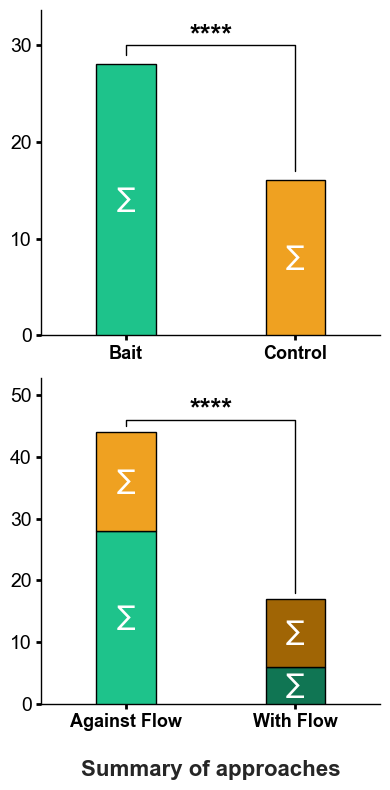

In [118]:
## make 1x2 plot of stacked bars for all conditions summed
# plot 1 is baited vs ctrl
# plot 2 is baited+ctrl vs upstream baited+upstream ctrl

print(f'sum of against flow bait: {sums_bait}')
print(f'sum of against flow control: {sums_ctrl}')
print(f'sum of with flow bait: {sums_upstream_bait}')
print(f'sum of with flow control: {sums_upstream_ctrl}')

## calculate expected values for sums_bait vs sums_ctrl
expected_proportion = length_bait / (length_bait + length_downstream_ctrl)
total_events = sums_bait + sums_ctrl
p_val_ec = stats.binomtest(sums_bait, total_events, expected_proportion, alternative='two-sided')
print(f'against flow bait vs against flow control: {p_val_ec}')

## calculate expected values for bait + downstream_ctrl vs upstream_bait + upstream_ctrl
expected_proportion = (length_bait + length_downstream_ctrl) / (length_bait + length_downstream_ctrl + length_upstream_bait + length_ctrl)
total_events = sums_bait + sums_ctrl + sums_upstream_bait + sums_upstream_ctrl
p_val_cc = stats.binomtest(sums_bait + sums_ctrl, total_events, expected_proportion, alternative='two-sided')
print(f'against flow bait + against flow control vs with flow bait + with flow control: {p_val_cc}')

## make figure
fig, axs = plt.subplots(2, 1, figsize=(4,8))

xlim = (-0.5, 1.5)
xticks = [0, 1]
bar_width = 0.35

### top plot ###
ax=axs[0]

yticks = [0, 10, 20, 30]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=14)

## make bar plots
ax.bar(0, sums_bait, color=color_key['Bait'], edgecolor='black', lw=1, zorder=3, width=bar_width)
ax.bar(1, sums_ctrl, color=color_key['Downstream_Ctrl'], edgecolor='black', lw=1, zorder=3, width=bar_width)

## draw pvalue line
pady = 1
offsety = 1
py = [sums_bait+offsety, sums_bait+offsety+pady, sums_bait+offsety+pady, sums_ctrl+offsety]
px = [0, 0, 1, 1]
ax.plot(px, py, lw=1, color='black', zorder=4)

## add pvalue text
pval = f'{convert_p_to_asterisks(p_val_ec.pvalue)}'
ax.text(0.5, sums_bait+offsety+pady/2, pval, fontsize=20, ha='center', va='bottom', fontweight='bold', color='black')

## add sum symbol to inside of bait bar
ax.text(0, sums_bait*(1/2), '$\\sum{}$', fontsize=14, ha='center', va='center', fontweight='bold', color='white')
## add sum symbol to inside of ctrl bar
ax.text(1, sums_ctrl*(1/2), '$\\sum{}$', fontsize=14, ha='center', va='center', fontweight='bold', color='white')

xlabs = ['Bait', 'Control']
ax.set_xticks(xticks)
ax.set_xticklabels(xlabs, fontsize=13, fontweight='bold')

ylim = (0, 1.2*max([sums_bait, sums_ctrl]))

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.grid(color='white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
## make the spline thicker and black
for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(1)
    ax.spines[axis].set_color('black')
## set ticks to visible
ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
## make the ticks markers thicker
ax.tick_params(axis='x', width=2, colors='black')
ax.tick_params(axis='y', width=2, colors='black')

### bottom plot ###
ax=axs[1]

yticks = [0, 10, 20, 30, 40, 50]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=14)

## make stacked bar plots
ax.bar(0, sums_bait, color=color_key['Bait'], edgecolor='black', lw=1, zorder=3, width=bar_width)
ax.bar(0, sums_ctrl, bottom=sums_bait, color=color_key['Downstream_Ctrl'], edgecolor='black', lw=1, zorder=3, width=bar_width)
ax.bar(1, sums_upstream_bait, color=color_key['Upstream_Bait'], edgecolor='black', lw=1, zorder=3, width=bar_width)
ax.bar(1, sums_upstream_ctrl, bottom=sums_upstream_bait, color=color_key['Ctrl'], edgecolor='black', lw=1, zorder=3, width=bar_width)

## draw pvalue line
pady = 1
offsety = 1
py = [sums_bait+sums_ctrl+offsety, sums_bait+sums_ctrl+offsety+pady, sums_bait+sums_ctrl+offsety+pady, sums_upstream_bait+sums_upstream_ctrl+offsety]
px = [0, 0, 1, 1]
ax.plot(px, py, lw=1, color='black', zorder=4)

## add pvalue text
pval = f'{convert_p_to_asterisks(p_val_cc.pvalue)}'
ax.text(0.5, sums_bait+sums_ctrl+offsety+pady/2, pval, fontsize=20, ha='center', va='bottom', fontweight='bold', color='black')

## add sum symbol to inside of bait bar
ax.text(0, sums_bait*(1/2), '$\\sum{}$', fontsize=14, ha='center', va='center', fontweight='bold', color='white')
## add sum symbol to inside of ctrl bar
ax.text(0, sums_ctrl*(1/2)+sums_bait, '$\\sum{}$', fontsize=14, ha='center', va='center', fontweight='bold', color='white')
## add sum symbol to inside of upstream bait bar
ax.text(1, sums_upstream_bait*(1/2), '$\\sum{}$', fontsize=14, ha='center', va='center', fontweight='bold', color='white')
## add sum symbol to inside of upstream ctrl bar
ax.text(1, sums_upstream_ctrl*(1/2)+sums_upstream_bait, '$\\sum{}$', fontsize=14, ha='center', va='center', fontweight='bold', color='white')

xlabel = '\nSummary of approaches'
ax.set_xlabel(xlabel, fontsize=16, fontweight='bold')

xlabs = ['Against Flow', 'With Flow']
ax.set_xticks(xticks)
ax.set_xticklabels(xlabs, fontsize=13, fontweight='bold')

ylim = (0, 1.2*max([sums_bait + sums_ctrl, sums_upstream_bait + sums_upstream_ctrl]))

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.grid(color='white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
## make the spline thicker and black
for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(1)
    ax.spines[axis].set_color('black')
## set ticks to visible
ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
## make the ticks markers thicker
ax.tick_params(axis='x', width=2, colors='black')
ax.tick_params(axis='y', width=2, colors='black')

fig.tight_layout()
fig_name = '3t-approaches_final-approach-all-condition-sums.png'
path_fig1 = os.path.join(root_dir, fig_name)
fig.savefig(path_fig1, dpi=300, bbox_inches='tight')

plt.show(fig)
plt.close(fig)